<a href="https://colab.research.google.com/github/applejxd/colaboratory/blob/master/algorithm/ODE_BVP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 前準備 (可視化等)

解のアニメーションを書くための関数を定義

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import animation



def save_animation(x, t, u_tx, ymin, ymax, filename):
    fig, ax = plt.subplots()

    # 共通設定
    ax.set_xlabel("$x$")
    ax.set_ylabel("$u(x)$")
    ax.set_ylim((ymin, ymax))

    # list of plot
    artists = []
    for t_idx in range(t.size):
        artist = ax.plot(x, u_tx[t_idx, :], '-b')
        # transform 指定で枠(左下)を基準にした挿入
        artist += [ax.text(0.05, 1.05, f"t = {t[t_idx]: .2f}", transform=ax.transAxes)]
        artists.append(artist)

    # アニメーション生成 (100ms 毎に更新=10fps)
    anim = animation.ArtistAnimation(fig, artists, interval=100, repeat=False)

    # アニメーション保存 (writer="pillow" or "imagemagick" for GIF)
    anim.save(filename, writer="pillow")  
    print(f"saved as '{filename}'")

## 線形2階微分方程式：自由場のシュレディンガー方程式

- 境界値問題として解く
- 境界条件は固定端条件
- 解くのは固有値問題

シュレディンガー方程式は
\begin{equation}
  \left(-\frac{\hbar^2}{2m}\nabla^2+U(x)\right) \psi(x) = E \psi(x)
\end{equation}
である。
1次元の場合に適切に無次元化すると
\begin{equation}
  \left(-\frac{d^2}{dx^2}+U(x)\right)\psi(x)=E\psi
\end{equation}
となる。
ハミルトニアンに含まれる2階微分の単純な差分表示は
\begin{equation}
\begin{split}
  &\left.\frac{d^2}{dx^2}\psi(x)\right|_{x=x_i}
  \sim\left.\frac{d}{dx}\frac{\psi(x+a/2)-\psi(x-a/2)}{a}\right|_{x=x_i} \\
  &\sim\left.\frac{d}{dx}\frac{\psi(x+a/2)-\psi(x-a/2)}{a}\right|_{x=x_i} \\
  &\sim\frac{\psi(x_i+a)-2\psi(x_i)+\psi(x_i-a)}{a^2}
\end{split}  
\end{equation}
となる。
これはいわゆるハミルトニアンの行列表示である。

以下、自由場の場合を境界値問題として解く。

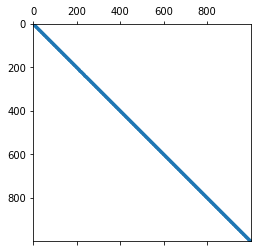

In [17]:
from scipy import sparse
import matplotlib.pyplot as plt

a = 0.01
N = 1000
hamiltonian = (-sparse.eye(N,k=1) + 2 * sparse.identity(N) 
               -sparse.eye(N,k=-1)) / a**2
plt.spy(hamiltonian, markersize=1)

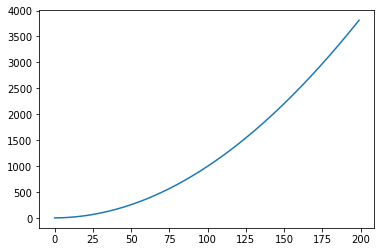

In [26]:
from scipy.sparse import linalg
import numpy as np

sn = 200
eigenvalues, eigenvectors = linalg.eigsh(hamiltonian, k=sn, which="SM")
eigenvectors = np.transpose(eigenvectors)

level = np.arange(sn)
print()
plt.plot(level, eigenvalues[level])

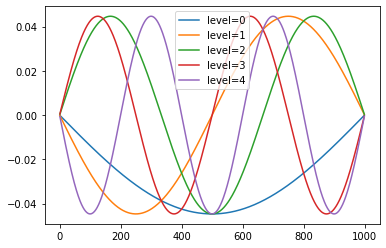

In [28]:
for i in range(5):
    plt.plot(eigenvectors[i], label='level=%d' %i)
plt.legend()

## 非線形放物線型偏微分方程式：バーガース方程式


\begin{equation}
\frac{∂u(x,t)}{∂t}+u(x,t)\frac{∂u(x,t)}{∂x}=ν\frac{∂^2u(x,t)}{∂x^2}
\end{equation}

## 非線形3階偏微分方程式：KdV 方程式

- 初期値問題として解く
- 空間方向は周期境界条件

[python で学ぶ計算物理](http://www.physics.okayama-u.ac.jp/~otsuki/lecture/CompPhys2/pde/kdv.html)から移植。典型的なパラメータの

\begin{equation}
\frac{∂u(x,t)}{∂t}+6u(x,t)\frac{∂u(x,t)}{∂x}+\frac{∂^3u(x,t)}{∂x^3}=0
\end{equation}

を数値的に解く。

空間差分による係数行列を定義

In [ ]:
import numpy as np
from scipy.sparse import csr_matrix as sparse_matrix


def make_differential_ops(nx: int, dx: float):
    # 周期境界条件
    f0 = np.identity(nx, dtype=int)  # f_{i}
    f1 = np.roll(f0, 1, axis=1)  # f_{i+1}
    f2 = np.roll(f0, 2, axis=1)  # f_{i+2}
    f_1 = f1.transpose()  # f_{i-1}
    f_2 = f2.transpose()  # f_{i-2}

    # (f_{i+1} - f_{i-1}) / (2 dx)
    deriv1 = sparse_matrix(f1 - f_1) / (2.0 * dx)

    # (f_{i+1} - 2f_{i} + f_{i-1}) / (dx^2)
    deriv2 = sparse_matrix(f1 - 2.0 * f0 + f_1) / dx**2

    # (f_{i+2} - 2f_{i+1} + 2f_{i-1} - f_{i-2}) / (2 dx^3)
    deriv3 = sparse_matrix(f2 - 2.0 * f1 + 2.0 * f_1 - f_2) / (2.0 * dx**3)

    return deriv1, deriv2, deriv3

KdV 方程式の空間差分による係数行列を定義

In [ ]:
def f_kdv(t, u, df1, df3):
    u_x = df1.dot(u)
    u_xxx = df3.dot(u)
    return -6.0 * u * u_x - u_xxx

時間方向へ数値積分を実施

In [ ]:
from scipy.integrate import solve_ivp

def kdv_integrate():
    # 空間メッシュ数
    nx = 1000
    # 空間幅
    x_max = 100.0
    # 空間メッシュ
    x = np.linspace(0, x_max, nx, endpoint=False)
    # 空間刻み幅
    dx = x[1] - x[0]
    print(f"dx = {dx}")

    # 初期条件
    u0 = np.sin(x * (2.0 * np.pi / x_max))

    # 微分演算子
    op_df1, _, op_df3 = make_differential_ops(nx, dx)

    print("計算開始...")
    t_max = 10.0
    sol = solve_ivp(f_kdv, (0, t_max), u0, args=(op_df1, op_df3),
                    dense_output=True, rtol=1e-8)
    print(sol.message)
    print(f" 時刻ステップ数　: {sol.t.size}")
    print(f" 時刻最小刻み幅　: {min(np.diff(sol.t))}")
    print(f" 時刻最大刻み幅　: {max(np.diff(sol.t))}")

    # 時間メッシュ数
    nt = 101
    # 時間メッシュ
    t = np.linspace(0, t_max, nt)
    # 時間メッシュ幅
    dt = t[1] - t[0]
    print(f"dt = {dt}")

    # u(x, t)
    u_xt = sol.sol(t)  
    # u(t, x)
    u_tx = u_xt.T  
    print(f"u(t, x) の形状: {u_tx.shape}")

    np.savez("kdv_solve_ivp", x=x, t=t, u_tx=u_tx)

In [ ]:
kdv_integrate()

dx = 0.1
計算開始...
The solver successfully reached the end of the integration interval.
 時刻ステップ数　: 24471
 時刻最小刻み幅　: 0.0002880236208611109
 時刻最大刻み幅　: 0.03763835219541923
dt = 0.1
u(t, x) の形状: (101, 1000)


アニメーションを描画

In [ ]:
def make_kdv_animation():
    # 結果読み込み
    npz = np.load("kdv_solve_ivp.npz")
    print(f"npz.files = {npz.files}")

    x = npz['x']
    t = npz['t']
    u_tx = npz['u_tx']
    print(f"x.shape = {x.shape}")
    print(f"t.shape = {t.shape}")
    print(f"u_tx.shape = {u_tx.shape}")

    print("アニメーション生成中...")
    save_animation(x, t, u_tx, ymin=-1.5, ymax=3.0, filename="kdv_solve_ivp.gif")

npz.files = ['x', 't', 'u_tx']
x.shape = (1000,)
t.shape = (101,)
u_tx.shape = (101, 1000)
アニメーション生成中...
saved as 'kdv_solve_ivp.gif'


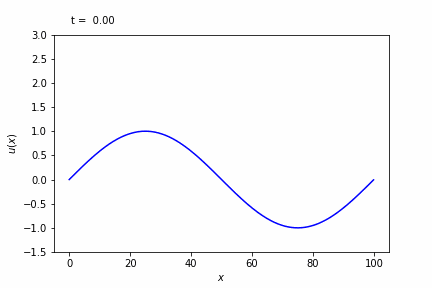

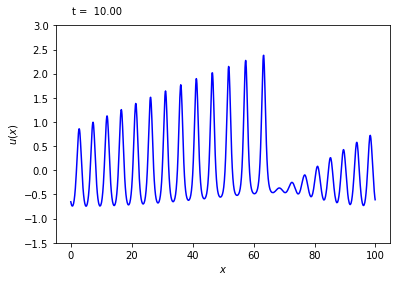

In [ ]:
make_kdv_animation()

In [ ]:
import IPython

# アニメーション再生
IPython.display.Image("kdv_solve_ivp.gif", format='png')